# 08 – Nested Cross-Validation (Transformers) + Model Comparison

Ziel:
- Robustere Evaluation durch Nested Cross-Validation:
  - Outer CV: echte Performance-Schätzung (Generalization)
  - Inner CV: Hyperparameter-Selection (z.B. LR, Epochs)
- Vergleich DistilBERT vs BERT inkl. Trainingszeit

Hinweis:
Nested CV ist rechenintensiv. Wir nutzen kleine Grid-Suche (wenige Kombinationen)
und optional nur 3 outer folds, um es im Zeitrahmen praktikabel zu halten.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import time
import torch

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    set_seed,
)

PROJECT_ROOT = Path.cwd().parent
DATA_CSV = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

RESULTS_DIR = PROJECT_ROOT / "results" / "nested_cv"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("CUDA available:", torch.cuda.is_available())
print("DATA_CSV:", DATA_CSV)
print("RESULTS_DIR:", RESULTS_DIR)


CUDA available: True
DATA_CSV: c:\CAS\cas-ml-document-classification\data\processed\bbc_news.csv
RESULTS_DIR: c:\CAS\cas-ml-document-classification\results\nested_cv


Data + Label Mapping

In [2]:
df = pd.read_csv(DATA_CSV)

labels_sorted = sorted(df["label"].unique())
label2id = {l:i for i,l in enumerate(labels_sorted)}
id2label = {i:l for l,i in label2id.items()}

X = df["text"].astype(str).values
y = df["label"].map(label2id).values

print("Samples:", len(X), "Classes:", labels_sorted)


Samples: 2225 Classes: ['business', 'entertainment', 'politics', 'sport', 'tech']


Tokenization

In [3]:
MAX_LENGTH = 256
SEED = 42

def tokenize_with(tokenizer, batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=MAX_LENGTH)

def make_hf_dataset(texts, labels, tokenizer):
    ds = Dataset.from_dict({"text": list(texts), "label": list(labels)})
    ds = ds.map(lambda b: tokenize_with(tokenizer, b), batched=True)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    return ds


Metrics

In [4]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": float(accuracy_score(labels, preds)),
        "macro_f1": float(f1_score(labels, preds, average="macro"))
    }


Train+Eval Function – mit Zeitmessung

In [6]:
def train_eval_once(
    model_name,
    train_texts, train_labels,
    eval_texts, eval_labels,
    lr=2e-5, epochs=2, batch_size=16,
    fold_tag="tmp",
    fp16=True
):
    set_seed(SEED)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_ds = make_hf_dataset(train_texts, train_labels, tokenizer)
    eval_ds  = make_hf_dataset(eval_texts, eval_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(labels_sorted),
        id2label=id2label,
        label2id=label2id
    )

    use_fp16 = bool(fp16 and torch.cuda.is_available())

    args = TrainingArguments(
        output_dir=str(RESULTS_DIR / f"tmp_{fold_tag}"),
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy="no",
        save_strategy="no",
        logging_strategy="no",
        report_to="none",
        seed=SEED,
        fp16=use_fp16
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    t0 = time.time()
    trainer.train()
    train_time = time.time() - t0

    metrics = trainer.evaluate()
    metrics["train_time_sec"] = float(train_time)

    # clean keys for consistency
    return {
        "eval_accuracy": float(metrics["eval_accuracy"]),
        "eval_macro_f1": float(metrics["eval_macro_f1"]),
        "eval_loss": float(metrics["eval_loss"]),
        "train_time_sec": float(metrics["train_time_sec"]),
    }


Nested CV Config – kleine Grid Search

In [7]:
# Outer folds: "echte" Performance-Schätzung
OUTER_SPLITS = 3

# Inner folds: Hyperparameter Auswahl
INNER_SPLITS = 2

# Kleiner Grid (bitte klein halten)
GRID = [
    {"lr": 2e-5, "epochs": 2, "batch_size": 16},
    {"lr": 5e-5, "epochs": 2, "batch_size": 16},
    {"lr": 2e-5, "epochs": 3, "batch_size": 16},
]

MODELS = [
    "distilbert-base-uncased",
    "bert-base-uncased"
]


Nested CV Run

In [8]:
outer_cv = StratifiedKFold(n_splits=OUTER_SPLITS, shuffle=True, random_state=SEED)

all_rows = []

for model_name in MODELS:
    print(f"\n==============================")
    print(f"MODEL: {model_name}")
    print(f"==============================")

    for outer_fold, (trainval_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_trainval, y_trainval = X[trainval_idx], y[trainval_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        # INNER CV for hyperparameter selection
        inner_cv = StratifiedKFold(n_splits=INNER_SPLITS, shuffle=True, random_state=SEED)
        grid_scores = []

        for g_i, cfg in enumerate(GRID, start=1):
            inner_acc = []
            inner_f1 = []
            inner_time = []

            for inner_fold, (tr_idx, va_idx) in enumerate(inner_cv.split(X_trainval, y_trainval), start=1):
                X_tr, y_tr = X_trainval[tr_idx], y_trainval[tr_idx]
                X_va, y_va = X_trainval[va_idx], y_trainval[va_idx]

                tag = f"{model_name.replace('/','_')}_outer{outer_fold}_g{g_i}_inner{inner_fold}"

                res = train_eval_once(
                    model_name=model_name,
                    train_texts=X_tr, train_labels=y_tr,
                    eval_texts=X_va, eval_labels=y_va,
                    lr=cfg["lr"], epochs=cfg["epochs"], batch_size=cfg["batch_size"],
                    fold_tag=tag,
                    fp16=True
                )

                inner_acc.append(res["eval_accuracy"])
                inner_f1.append(res["eval_macro_f1"])
                inner_time.append(res["train_time_sec"])

            grid_scores.append({
                **cfg,
                "inner_acc_mean": float(np.mean(inner_acc)),
                "inner_f1_mean": float(np.mean(inner_f1)),
                "inner_time_mean": float(np.mean(inner_time))
            })

        grid_df = pd.DataFrame(grid_scores).sort_values(
            ["inner_f1_mean", "inner_acc_mean"], ascending=False
        )

        best_cfg = grid_df.iloc[0].to_dict()
        print(f"\nOuter fold {outer_fold}: Best cfg:", {k: best_cfg[k] for k in ["lr","epochs","batch_size"]})
        print(grid_df)

        # Train final on full trainval with best cfg, evaluate on outer test fold
        tag_final = f"{model_name.replace('/','_')}_outer{outer_fold}_FINAL"
        final_res = train_eval_once(
            model_name=model_name,
            train_texts=X_trainval, train_labels=y_trainval,
            eval_texts=X_test, eval_labels=y_test,
            lr=best_cfg["lr"], epochs=int(best_cfg["epochs"]), batch_size=int(best_cfg["batch_size"]),
            fold_tag=tag_final,
            fp16=True
        )

        all_rows.append({
            "model": model_name,
            "outer_fold": outer_fold,
            "best_lr": best_cfg["lr"],
            "best_epochs": int(best_cfg["epochs"]),
            "best_batch_size": int(best_cfg["batch_size"]),
            "outer_eval_accuracy": final_res["eval_accuracy"],
            "outer_eval_macro_f1": final_res["eval_macro_f1"],
            "outer_eval_loss": final_res["eval_loss"],
            "train_time_sec": final_res["train_time_sec"],
        })

nested_df = pd.DataFrame(all_rows)
nested_df



MODEL: distilbert-base-uncased


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 4.302, 'train_samples_per_second': 344.49, 'train_steps_per_second': 21.85, 'train_loss': 0.880440001792096, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 3.9277, 'train_samples_per_second': 377.826, 'train_steps_per_second': 23.932, 'train_loss': 0.8973838319169715, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 3.94, 'train_samples_per_second': 376.143, 'train_steps_per_second': 23.858, 'train_loss': 0.42890370145757145, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 3.8617, 'train_samples_per_second': 384.285, 'train_steps_per_second': 24.341, 'train_loss': 0.44496203483419217, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/141 [00:00<?, ?it/s]

{'train_runtime': 5.9056, 'train_samples_per_second': 376.421, 'train_steps_per_second': 23.876, 'train_loss': 0.5944188435872396, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/141 [00:00<?, ?it/s]

{'train_runtime': 5.8996, 'train_samples_per_second': 377.311, 'train_steps_per_second': 23.9, 'train_loss': 0.604056013391373, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]


Outer fold 1: Best cfg: {'lr': 2e-05, 'epochs': 3.0, 'batch_size': 16.0}
        lr  epochs  batch_size  inner_acc_mean  inner_f1_mean  inner_time_mean
2  0.00002       3          16        0.977076       0.976661         6.005747
1  0.00005       2          16        0.975728       0.975538         3.999527
0  0.00002       2          16        0.967635       0.967242         4.418780


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1483 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/279 [00:00<?, ?it/s]

{'train_runtime': 11.9012, 'train_samples_per_second': 373.828, 'train_steps_per_second': 23.443, 'train_loss': 0.2961193344499048, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 3.9772, 'train_samples_per_second': 372.621, 'train_steps_per_second': 23.635, 'train_loss': 0.8536872863769531, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 3.9368, 'train_samples_per_second': 376.954, 'train_steps_per_second': 23.877, 'train_loss': 0.8838881634651347, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 3.8373, 'train_samples_per_second': 386.207, 'train_steps_per_second': 24.496, 'train_loss': 0.42279555949758973, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 3.8509, 'train_samples_per_second': 385.36, 'train_steps_per_second': 24.41, 'train_loss': 0.43528605521993435, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/141 [00:00<?, ?it/s]

{'train_runtime': 5.8762, 'train_samples_per_second': 378.304, 'train_steps_per_second': 23.995, 'train_loss': 0.5752901658944204, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/141 [00:00<?, ?it/s]

{'train_runtime': 5.8969, 'train_samples_per_second': 377.485, 'train_steps_per_second': 23.911, 'train_loss': 0.5944107813192597, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]


Outer fold 2: Best cfg: {'lr': 2e-05, 'epochs': 3.0, 'batch_size': 16.0}
        lr  epochs  batch_size  inner_acc_mean  inner_f1_mean  inner_time_mean
2  0.00002       3          16        0.977073       0.976883         5.992453
1  0.00005       2          16        0.975049       0.974680         3.945168
0  0.00002       2          16        0.971679       0.971416         4.066165


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1483 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/279 [00:00<?, ?it/s]

{'train_runtime': 11.709, 'train_samples_per_second': 379.964, 'train_steps_per_second': 23.828, 'train_loss': 0.3046051353536626, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 4.0312, 'train_samples_per_second': 368.129, 'train_steps_per_second': 23.318, 'train_loss': 0.8675365042179188, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 3.9655, 'train_samples_per_second': 374.23, 'train_steps_per_second': 23.705, 'train_loss': 0.873240775250374, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 3.8397, 'train_samples_per_second': 386.492, 'train_steps_per_second': 24.481, 'train_loss': 0.4165417691494556, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 3.9467, 'train_samples_per_second': 376.009, 'train_steps_per_second': 23.817, 'train_loss': 0.4362683803477186, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/141 [00:00<?, ?it/s]

{'train_runtime': 5.9267, 'train_samples_per_second': 375.588, 'train_steps_per_second': 23.791, 'train_loss': 0.5808809970287566, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/141 [00:00<?, ?it/s]

{'train_runtime': 5.8923, 'train_samples_per_second': 377.781, 'train_steps_per_second': 23.93, 'train_loss': 0.5871452710307237, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]


Outer fold 3: Best cfg: {'lr': 5e-05, 'epochs': 2.0, 'batch_size': 16.0}
        lr  epochs  batch_size  inner_acc_mean  inner_f1_mean  inner_time_mean
1  0.00005       2          16        0.975741       0.975825         3.993089
2  0.00002       3          16        0.973720       0.973124         6.012177
0  0.00002       2          16        0.967655       0.967281         4.101119


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/186 [00:00<?, ?it/s]

{'train_runtime': 7.8004, 'train_samples_per_second': 380.493, 'train_steps_per_second': 23.845, 'train_loss': 0.23327216281685778, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]


MODEL: bert-base-uncased


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 5.9278, 'train_samples_per_second': 250.008, 'train_steps_per_second': 15.857, 'train_loss': 0.9725982990670712, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 5.9174, 'train_samples_per_second': 250.784, 'train_steps_per_second': 15.885, 'train_loss': 0.95416259765625, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 5.9165, 'train_samples_per_second': 250.486, 'train_steps_per_second': 15.888, 'train_loss': 0.4157418190164769, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 5.9501, 'train_samples_per_second': 249.408, 'train_steps_per_second': 15.798, 'train_loss': 0.4759474409387467, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/141 [00:00<?, ?it/s]

{'train_runtime': 8.8446, 'train_samples_per_second': 251.34, 'train_steps_per_second': 15.942, 'train_loss': 0.6733482847822473, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/141 [00:00<?, ?it/s]

{'train_runtime': 8.6484, 'train_samples_per_second': 257.389, 'train_steps_per_second': 16.304, 'train_loss': 0.6293239187687001, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]


Outer fold 1: Best cfg: {'lr': 2e-05, 'epochs': 3.0, 'batch_size': 16.0}
        lr  epochs  batch_size  inner_acc_mean  inner_f1_mean  inner_time_mean
2  0.00002       3          16        0.981122       0.981033         8.862282
1  0.00005       2          16        0.978421       0.978512         6.046600
0  0.00002       2          16        0.966957       0.966378         6.030769


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1483 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/279 [00:00<?, ?it/s]

{'train_runtime': 17.2276, 'train_samples_per_second': 258.248, 'train_steps_per_second': 16.195, 'train_loss': 0.29428573663089436, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 5.8047, 'train_samples_per_second': 255.311, 'train_steps_per_second': 16.194, 'train_loss': 0.8785367925116356, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 5.7741, 'train_samples_per_second': 257.01, 'train_steps_per_second': 16.28, 'train_loss': 1.0152873587101063, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 5.8022, 'train_samples_per_second': 255.418, 'train_steps_per_second': 16.201, 'train_loss': 0.44542856419340093, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 5.806, 'train_samples_per_second': 255.598, 'train_steps_per_second': 16.19, 'train_loss': 0.49064064025878906, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/141 [00:00<?, ?it/s]

{'train_runtime': 8.6749, 'train_samples_per_second': 256.256, 'train_steps_per_second': 16.254, 'train_loss': 0.58581391463043, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/141 [00:00<?, ?it/s]

{'train_runtime': 8.6627, 'train_samples_per_second': 256.963, 'train_steps_per_second': 16.277, 'train_loss': 0.6993545640444925, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]


Outer fold 2: Best cfg: {'lr': 5e-05, 'epochs': 2.0, 'batch_size': 16.0}
        lr  epochs  batch_size  inner_acc_mean  inner_f1_mean  inner_time_mean
1  0.00005       2          16        0.977746       0.977293         5.918922
2  0.00002       3          16        0.973701       0.973621         8.783134
0  0.00002       2          16        0.967628       0.967549         5.901927


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1483 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/186 [00:00<?, ?it/s]

{'train_runtime': 11.638, 'train_samples_per_second': 254.854, 'train_steps_per_second': 15.982, 'train_loss': 0.2797582687870149, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 5.7916, 'train_samples_per_second': 256.233, 'train_steps_per_second': 16.23, 'train_loss': 0.9414558410644531, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 5.7828, 'train_samples_per_second': 256.622, 'train_steps_per_second': 16.255, 'train_loss': 0.9756859312666223, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 5.8572, 'train_samples_per_second': 253.363, 'train_steps_per_second': 16.049, 'train_loss': 0.48516427709701215, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/94 [00:00<?, ?it/s]

{'train_runtime': 5.8009, 'train_samples_per_second': 255.821, 'train_steps_per_second': 16.204, 'train_loss': 0.4540797294454372, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/141 [00:00<?, ?it/s]

{'train_runtime': 8.7056, 'train_samples_per_second': 255.697, 'train_steps_per_second': 16.196, 'train_loss': 0.6375700497458167, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/141 [00:00<?, ?it/s]

{'train_runtime': 8.6923, 'train_samples_per_second': 256.089, 'train_steps_per_second': 16.221, 'train_loss': 0.6436388272765681, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]


Outer fold 3: Best cfg: {'lr': 5e-05, 'epochs': 2.0, 'batch_size': 16.0}
        lr  epochs  batch_size  inner_acc_mean  inner_f1_mean  inner_time_mean
1  0.00005       2          16        0.979111       0.978777         5.948338
2  0.00002       3          16        0.973046       0.973142         8.817989
0  0.00002       2          16        0.964960       0.964443         5.906805


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/186 [00:00<?, ?it/s]

{'train_runtime': 11.6186, 'train_samples_per_second': 255.452, 'train_steps_per_second': 16.009, 'train_loss': 0.2946661877375777, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

,model,outer_fold,best_lr,best_epochs,best_batch_size,outer_eval_accuracy,outer_eval_macro_f1,outer_eval_loss,train_time_sec
0,distilbert-base-uncased,1,0.00002,3,16,0.977089,0.976825,0.091795,12.005772
1,distilbert-base-uncased,2,0.00002,3,16,0.986523,0.986741,0.069841,11.809747
2,distilbert-base-uncased,3,0.00005,2,16,0.981107,0.981035,0.079107,7.914441
3,bert-base-uncased,1,0.00002,3,16,0.978437,0.978138,0.083333,17.338336
4,bert-base-uncased,2,0.00005,2,16,0.982480,0.982801,0.067659,11.757799
5,bert-base-uncased,3,0.00005,2,16,0.985155,0.985267,0.061461,11.737248


Summary Mean ± Std + Export

In [9]:
out_folds = RESULTS_DIR / "nested_cv_folds.csv"
nested_df.to_csv(out_folds, index=False)

summary = (
    nested_df.groupby("model")[["outer_eval_accuracy","outer_eval_macro_f1","train_time_sec"]]
    .agg(["mean","std"])
)
out_sum = RESULTS_DIR / "nested_cv_summary.csv"
summary.to_csv(out_sum)

out_folds, out_sum, summary


(WindowsPath('c:/CAS/cas-ml-document-classification/results/nested_cv/nested_cv_folds.csv'),
 WindowsPath('c:/CAS/cas-ml-document-classification/results/nested_cv/nested_cv_summary.csv'),
                         outer_eval_accuracy           outer_eval_macro_f1  \
                                        mean       std                mean   
 model                                                                       
 bert-base-uncased                  0.982024  0.003382            0.982069   
 distilbert-base-uncased            0.981573  0.004734            0.981534   
 
                                   train_time_sec            
                               std           mean       std  
 model                                                       
 bert-base-uncased        0.003621      13.611128  3.227874  
 distilbert-base-uncased  0.004977      10.576653  2.307626  )

Plot: Model Comparison

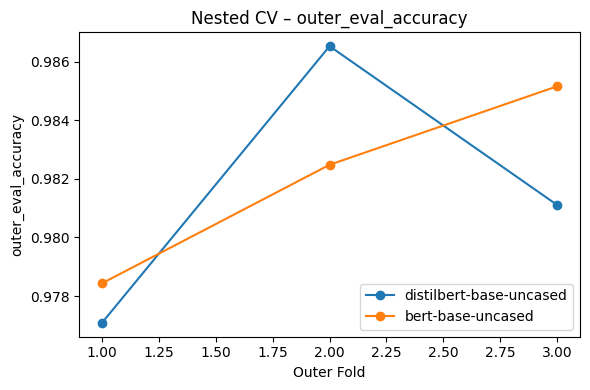

Saved: c:\CAS\cas-ml-document-classification\results\nested_cv\nested_cv_outer_eval_accuracy.png


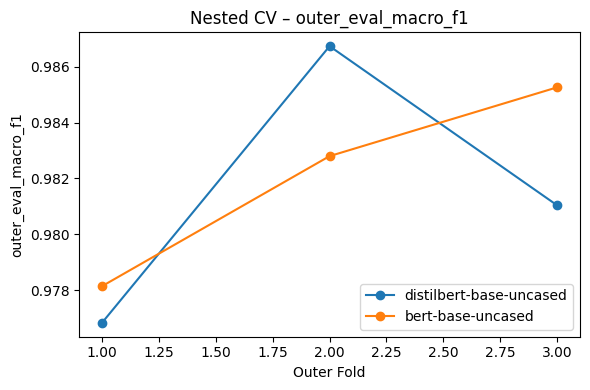

Saved: c:\CAS\cas-ml-document-classification\results\nested_cv\nested_cv_outer_eval_macro_f1.png


In [10]:
import matplotlib.pyplot as plt

for metric in ["outer_eval_accuracy", "outer_eval_macro_f1"]:
    plt.figure(figsize=(6,4))
    for model_name in nested_df["model"].unique():
        sub = nested_df[nested_df["model"] == model_name].sort_values("outer_fold")
        plt.plot(sub["outer_fold"], sub[metric], marker="o", label=model_name)

    plt.xlabel("Outer Fold")
    plt.ylabel(metric)
    plt.title(f"Nested CV – {metric}")
    plt.legend()
    plt.tight_layout()
    p = RESULTS_DIR / f"nested_cv_{metric}.png"
    plt.savefig(p, dpi=300)
    plt.show()
    print("Saved:", p)


Plot: Mean ± Std (Robustheit)

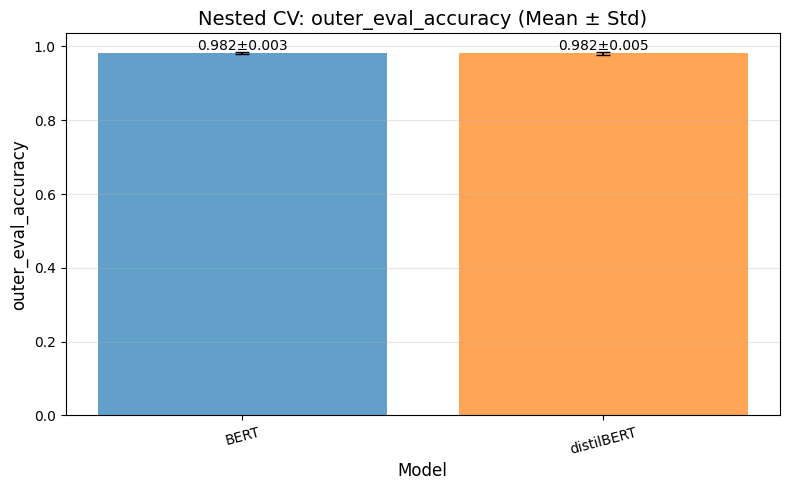

Saved: c:\CAS\cas-ml-document-classification\results\nested_cv\nested_cv_outer_eval_accuracy_barplot.png


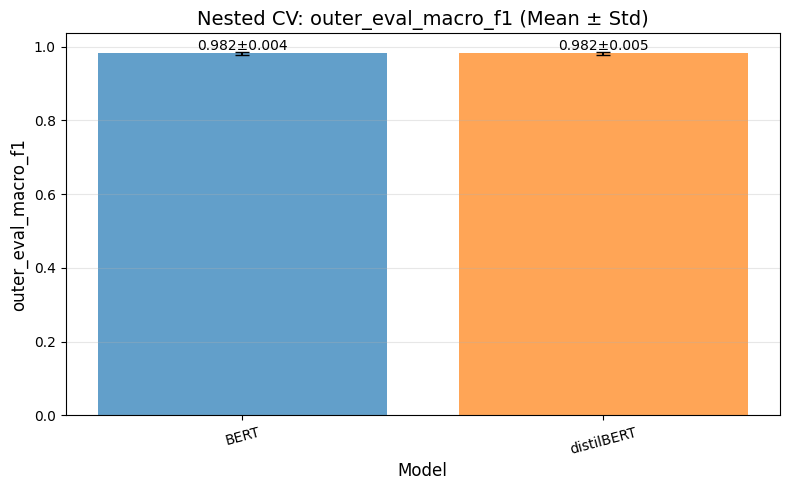

Saved: c:\CAS\cas-ml-document-classification\results\nested_cv\nested_cv_outer_eval_macro_f1_barplot.png


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Berechne mean ± std für jedes Modell
stats = nested_df.groupby("model")[["outer_eval_accuracy", "outer_eval_macro_f1"]].agg(["mean", "std"])

for metric in ["outer_eval_accuracy", "outer_eval_macro_f1"]:
    fig, ax = plt.subplots(figsize=(8, 5))
    
    models = stats.index
    means = stats[(metric, "mean")].values
    stds = stats[(metric, "std")].values
    
    x_pos = np.arange(len(models))
    
    # Balken mit Error Bars
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, color=['#1f77b4', '#ff7f0e'])
    
    # Beschriftung
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f"Nested CV: {metric} (Mean ± Std)", fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([m.replace("bert-base-uncased", "BERT").replace("distilbert-base-uncased", "DistilBERT") for m in models], rotation=15)
    ax.grid(axis='y', alpha=0.3)
    
    # Werte über den Balken
    for i, (mean, std) in enumerate(zip(means, stds)):
        ax.text(i, mean + std + 0.005, f"{mean:.3f}±{std:.3f}", ha='center', fontsize=10)
    
    plt.tight_layout()
    p = RESULTS_DIR / f"nested_cv_{metric}_barplot.png"
    plt.savefig(p, dpi=300)
    plt.show()
    print("Saved:", p)